In [1]:
def racnt(image, rad_interval=None, normalize=True):
    '''
    calculate the radial average power spectrum of an image
    Parameters
    ----------
    image : 2D numpy array
        The image to calculate the radial counts. Should be square.

    Returns
    -------
    X, Y : 1D numpy arrays
        X ranges from -0.5*sqrt(2), to 0.5*sqrt(2). Y is counts normalized to 1.
    '''

    import numpy as np

    x_sampling = np.linspace(-0.5, 0.5, image.shape[0])
    xx, yy = np.meshgrid(x_sampling, x_sampling)
    rad = np.sqrt(xx**2 + yy**2)
    if rad_interval is None:
        rad_interval = x_sampling[1] - x_sampling[0]

    X = np.arange(0, np.ceil(0.5/rad_interval)) * rad_interval
    Y = np.zeros(X.shape, dtype=np.float64)
    for i, x in enumerate(X):
        mask = np.logical_and(max(0, x - rad_interval/2) <= rad,
                              rad < x + rad_interval/2)
        Y[i] = np.sum(image[mask]) / (max(np.sum(mask), 1))
    if normalize:
        return X, Y / Y.max()
    else:
        return X, Y

## Diffraction Pattern Collected on Different Angle

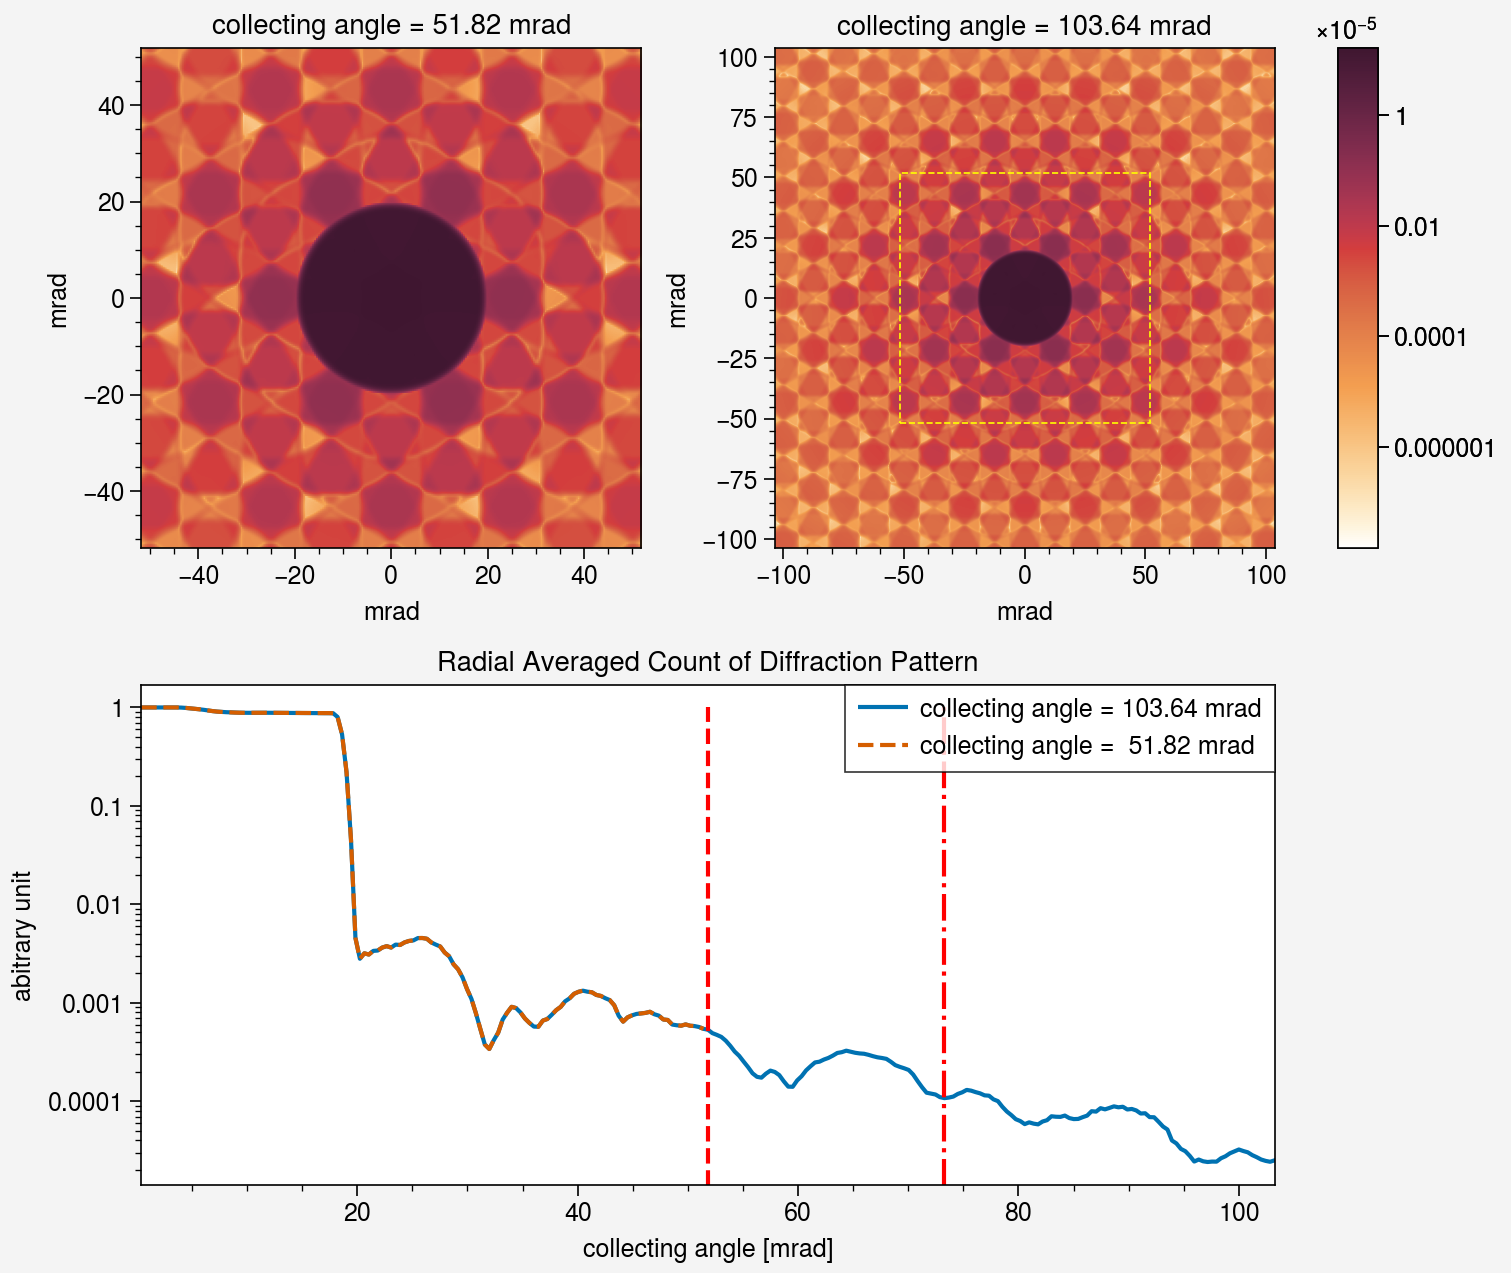

In [2]:
import numpy as np
import proplot as pplt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import h5py

with h5py.File(r'd:\Users\yiran.lu\Nextcloud\122 - WSe2 Simulation\IAMMeasurements_CrystalPotential.abtem.hdf5') as f:
    DP_00D = np.flipud(f['/array'][0, 0, :, :].T)
with h5py.File(r'd:\Users\yiran.lu\Nextcloud\128 - AAAnotherWSe2Simulation\IAMMeasurements_CrystalPotential.abtem.hdf5') as f:
    DP_00T = np.flipud(f['/array'][0, 0, :, :].T)

fig, (ax1, ax2, ax3) = pplt.subplots(
    array=[
        [1, 2],
        [3, 3]
    ],
    share=False
)
vmax = max(DP_00D.max(), DP_00T.max())
vmin = min(DP_00D.min(), DP_00T.min())

ax1.imshow(DP_00D, extent=[-51.8223742450, 51.8223742450, -51.8223742450, 51.8223742450],
            norm=LogNorm(),
           vmin=vmin, vmax=vmax)
ax1.format(title='collecting angle = 51.82 mrad')
m = ax2.imshow(DP_00T, extent=[-51.8223742450*2, 51.8223742450*2, -51.8223742450*2, 51.8223742450*2],
                norm=LogNorm(),
               vmin=vmin, vmax=vmax)
ax2.format(title='collecting angle = 103.64 mrad')
ax1.format(xlabel='mrad', ylabel='mrad')
ax2.format(xlabel='mrad', ylabel='mrad')
ax2.add_artist(plt.Rectangle((-51.8223742450, -51.8223742450), 51.8223742450*2, 51.8223742450*2, color='yellow', fill=False, linestyle='--'))
fig.colorbar(m, loc='r', row=1)

DP_00D_X, DP_00D_Y = racnt(DP_00D)
DP_00T_X, DP_00T_Y = racnt(DP_00T)

ax3.plot(DP_00T_X[1:] * 51.8223742450*2 * 2, DP_00T_Y[1:],
         label='collecting angle = 103.64 mrad')
ax3.plot(DP_00D_X[1:] * 51.8223742450 * 2, DP_00D_Y[1:], linestyle='--',
         label='collecting angle =  51.82 mrad')
ax3.format(yscale='log', title='Radial Averaged Count of Diffraction Pattern')
ax3.format(xlabel='collecting angle [mrad]', ylabel='abitrary unit')
ax3.legend(ncols=1, loc='upper right')

ax3.plot([51.8223742450, 51.8223742450], [0, 1], linestyle='--', color='red')
ax3.plot([np.sqrt(2)*51.8223742450, np.sqrt(2)*51.8223742450], [0, 1], linestyle='-.', color='red')

pplt.show()

## Reconstruction

### EPIE padding 1 Diffraction Pattern

In [3]:
import h5py
from numpy import fft

with h5py.File(r'd:\Users\yiran.lu\Nextcloud\122 - WSe2 Simulation\dataset_025\results\task_SimWSe2_025_PtyPy_EPIE_100_padding_1\recons\ipykernel_launcher_EPIE_pycuda_0100.ptyr') as f:
    probe_wf = np.squeeze(f['/content/probe/Sscan_00G00/data'][()])
    trans_wf = np.squeeze(f['/content/obj/Sscan_00G00/data'][()])

dp_EPIE1 = np.flipud(np.abs(fft.fftshift(fft.fft2(probe_wf * trans_wf[:probe_wf.shape[0], :probe_wf.shape[1]])))**2)
dp_EPIE1 /= dp_EPIE1.sum()

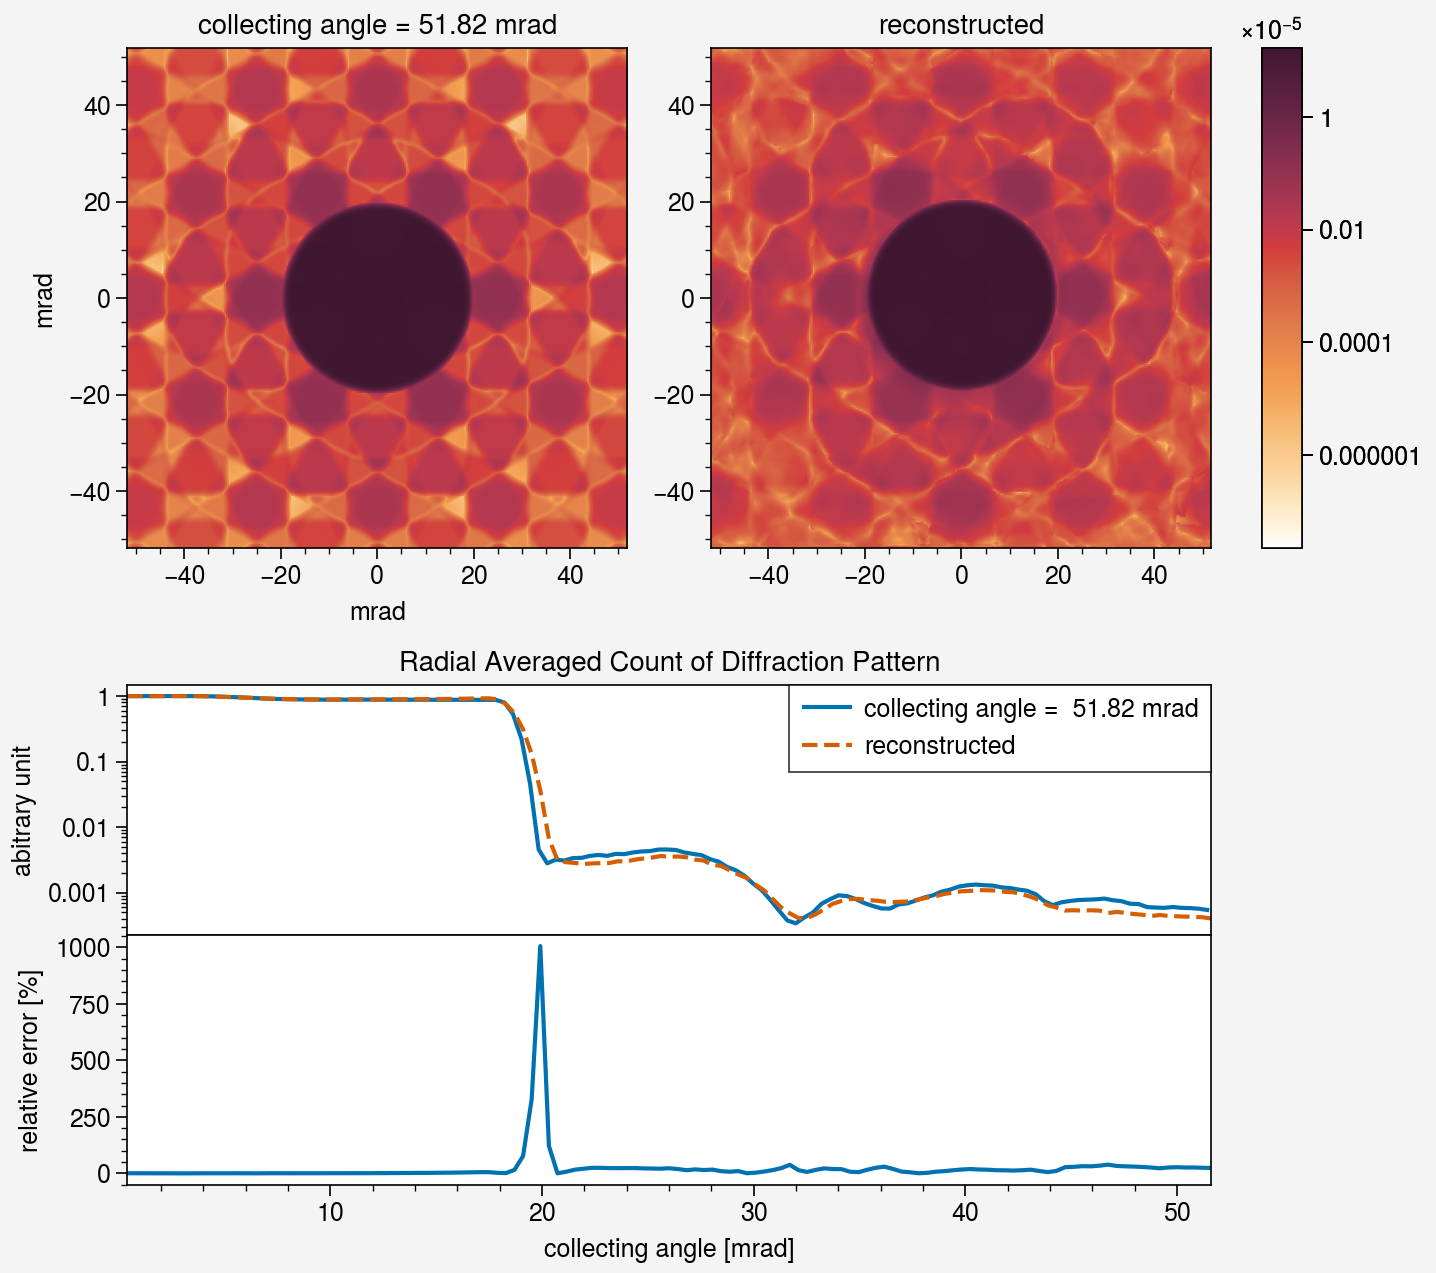

In [4]:
fig, (ax1, ax2, ax3, ax4) = pplt.subplots(
    array=[
        [1, 1, 2, 2],
        [1, 1, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4]
    ],
    share=False,
    hspace=(0, None, 0)
)
vmax = max(DP_00D.max(), dp_EPIE1.max())
vmin = min(DP_00D.min(), dp_EPIE1.min())

ax1.imshow(DP_00D, extent=[-51.8223742450, 51.8223742450, -51.8223742450, 51.8223742450],
            norm=LogNorm(),
           vmin=vmin, vmax=vmax)
ax1.format(title='collecting angle = 51.82 mrad')
m = ax2.imshow(dp_EPIE1, extent=[-51.8223742450, 51.8223742450, -51.8223742450, 51.8223742450],
                norm=LogNorm(),
               vmin=vmin, vmax=vmax)
ax2.format(title='reconstructed')
ax1.format(xlabel='mrad', ylabel='mrad')
fig.colorbar(m, loc='r', row=(1,2))

DP_00D_X, DP_00D_Y = racnt(DP_00D)
dp_EPIE1_X, dp_EPIE1_Y = racnt(dp_EPIE1)

ax3.plot(DP_00D_X[1:] * 51.8223742450 * 2, DP_00D_Y[1:],
         label='collecting angle =  51.82 mrad')
ax3.plot(dp_EPIE1_X[1:] * 51.8223742450 * 2, dp_EPIE1_Y[1:], linestyle='--',
         label='reconstructed')
ax3.format(yscale='log', title='Radial Averaged Count of Diffraction Pattern')
ax3.format(xlabel='collecting angle [mrad]', ylabel='abitrary unit')
ax3.legend(ncols=1, loc='upper right')

from scipy.interpolate import CubicSpline
f = CubicSpline(DP_00D_X, DP_00D_Y)
error_EPIE1 = np.abs((dp_EPIE1_Y - f(dp_EPIE1_X)) / f(dp_EPIE1_X) * 100)
ax4.plot(dp_EPIE1_X[1:] * 51.8223742450 * 2, error_EPIE1[1:])
ax4.format(xlabel='collecting angle [mrad]', ylabel='relative error [%]')

pplt.show()

### EPIE padding 2 Diffraction Pattern

In [11]:
import h5py
from numpy import fft

#with h5py.File(r'd:\Users\yiran.lu\Nextcloud\122 - WSe2 Simulation\dataset_025\results\task_SimWSe2_025_PtyPy_EPIE_100_padding_2\recons\ipykernel_launcher_EPIE_pycuda_0100.ptyr') as f:
with h5py.File(r'd:\Users\yiran.lu\Nextcloud\122 - WSe2 Simulation\dataset_025\results\task_SimWSe2_025_PtyPy_EPIE_100_padding_2_slower_convergence\recons\ipykernel_launcher_EPIE_pycuda_0100.ptyr') as f:
    probe_wf = np.squeeze(f['/content/probe/Sscan_00G00/data'][()])
    trans_wf = np.squeeze(f['/content/obj/Sscan_00G00/data'][()])

dp_EPIE2 = np.flipud(np.abs(fft.fftshift(fft.fft2(probe_wf * trans_wf[:probe_wf.shape[0], :probe_wf.shape[1]])))**2)
dp_EPIE2 /= dp_EPIE2.sum()

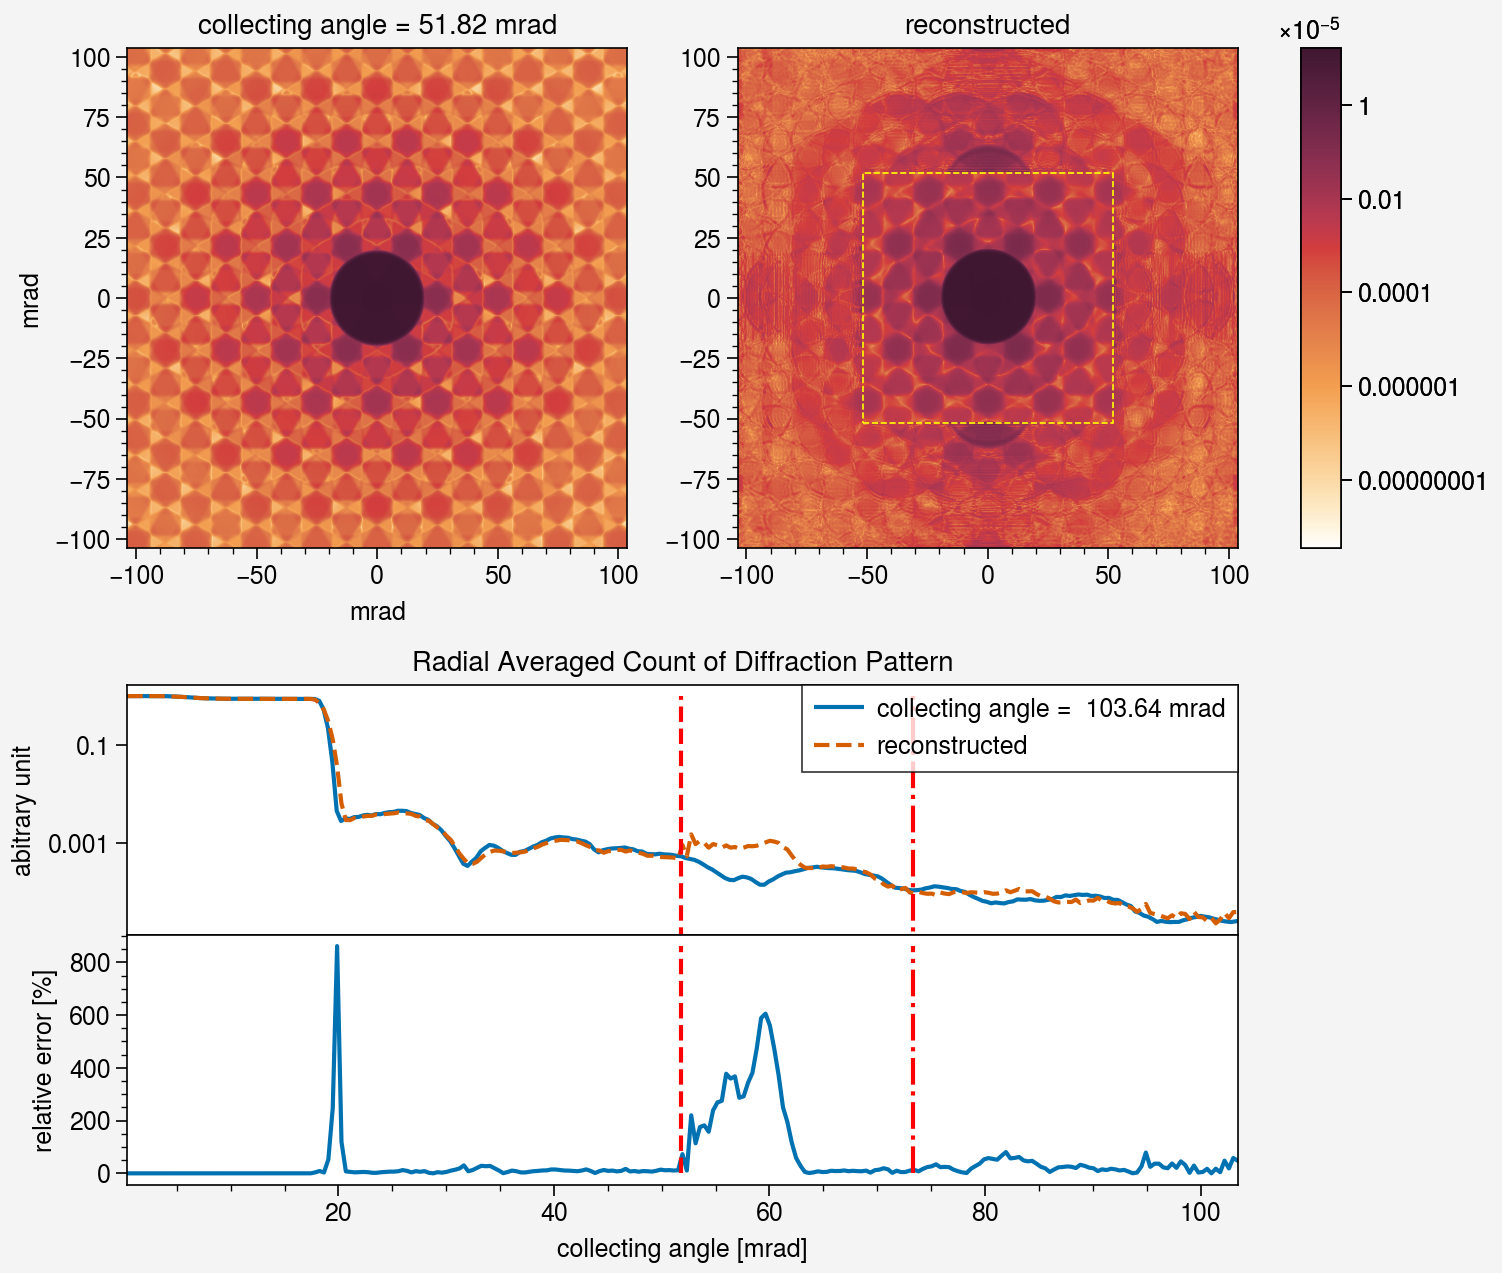

In [12]:
fig, (ax1, ax2, ax3, ax4) = pplt.subplots(
    array=[
        [1, 1, 2, 2],
        [1, 1, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4]
    ],
    share=False,
    hspace=(0, None, 0)
)
vmax = max(DP_00T.max(), dp_EPIE2.max())
vmin = min(DP_00T.min(), dp_EPIE2.min())

ax1.imshow(DP_00T, extent=[-51.8223742450*2, 51.8223742450*2, -51.8223742450*2, 51.8223742450*2],
            norm=LogNorm(),
           vmin=vmin, vmax=vmax)
ax1.format(title='collecting angle = 51.82 mrad')
m = ax2.imshow(dp_EPIE2, extent=[-51.8223742450*2, 51.8223742450*2, -51.8223742450*2, 51.8223742450*2],
                norm=LogNorm(),
               vmin=vmin, vmax=vmax)
ax2.format(title='reconstructed')
ax1.format(xlabel='mrad', ylabel='mrad')
ax2.add_artist(plt.Rectangle((-51.8223742450, -51.8223742450), 51.8223742450*2, 51.8223742450*2, color='yellow', fill=False, linestyle='--'))
fig.colorbar(m, loc='r', row=(1,2))

DP_00T_X, DP_00T_Y = racnt(DP_00T)
dp_EPIE2_X, dp_EPIE2_Y = racnt(dp_EPIE2)

ax3.plot(DP_00T_X[1:] * 51.8223742450*2 * 2, DP_00T_Y[1:],
         label='collecting angle =  103.64 mrad')
ax3.plot(dp_EPIE2_X[1:] * 51.8223742450*2 * 2, dp_EPIE2_Y[1:], linestyle='--',
         label='reconstructed')
ax3.format(yscale='log', title='Radial Averaged Count of Diffraction Pattern')
ax3.format(xlabel='collecting angle [mrad]', ylabel='abitrary unit')
ax3.legend(ncols=1, loc='upper right')

ax3.plot([51.8223742450, 51.8223742450], [0, 1], linestyle='--', color='red')
ax3.plot([np.sqrt(2)*51.8223742450, np.sqrt(2)*51.8223742450], [0, 1], linestyle='-.', color='red')

from scipy.interpolate import CubicSpline
f = CubicSpline(DP_00T_X, DP_00T_Y)
error_EPIE2 = np.abs((dp_EPIE2_Y - f(dp_EPIE2_X)) / f(dp_EPIE2_X) * 100)
ax4.plot(dp_EPIE2_X[1:] * 51.8223742450*2 * 2, error_EPIE2[1:])
ax4.plot([51.8223742450, 51.8223742450], [0, error_EPIE2.max()], linestyle='--', color='red')
ax4.plot([np.sqrt(2)*51.8223742450, np.sqrt(2)*51.8223742450], [0, error_EPIE2.max()], linestyle='-.', color='red')
ax4.format(xlabel='collecting angle [mrad]', ylabel='relative error [%]')

pplt.show()

### EPIE padding 1 Diffraction Pattern Full Support

In [7]:
import h5py
from numpy import fft

with h5py.File(r'd:\Users\yiran.lu\Nextcloud\122 - WSe2 Simulation\dataset_025\results\task_SimWSe2_025_PtyPy_EPIE_100_padding_1_full_support\recons\ipykernel_launcher_EPIE_pycuda_0100.ptyr') as f:
    probe_wf = np.squeeze(f['/content/probe/Sscan_00G00/data'][()])
    trans_wf = np.squeeze(f['/content/obj/Sscan_00G00/data'][()])

dp_EPIE1_f = np.flipud(np.abs(fft.fftshift(fft.fft2(probe_wf * trans_wf[:probe_wf.shape[0], :probe_wf.shape[1]])))**2)
dp_EPIE1_f /= dp_EPIE1_f.sum()

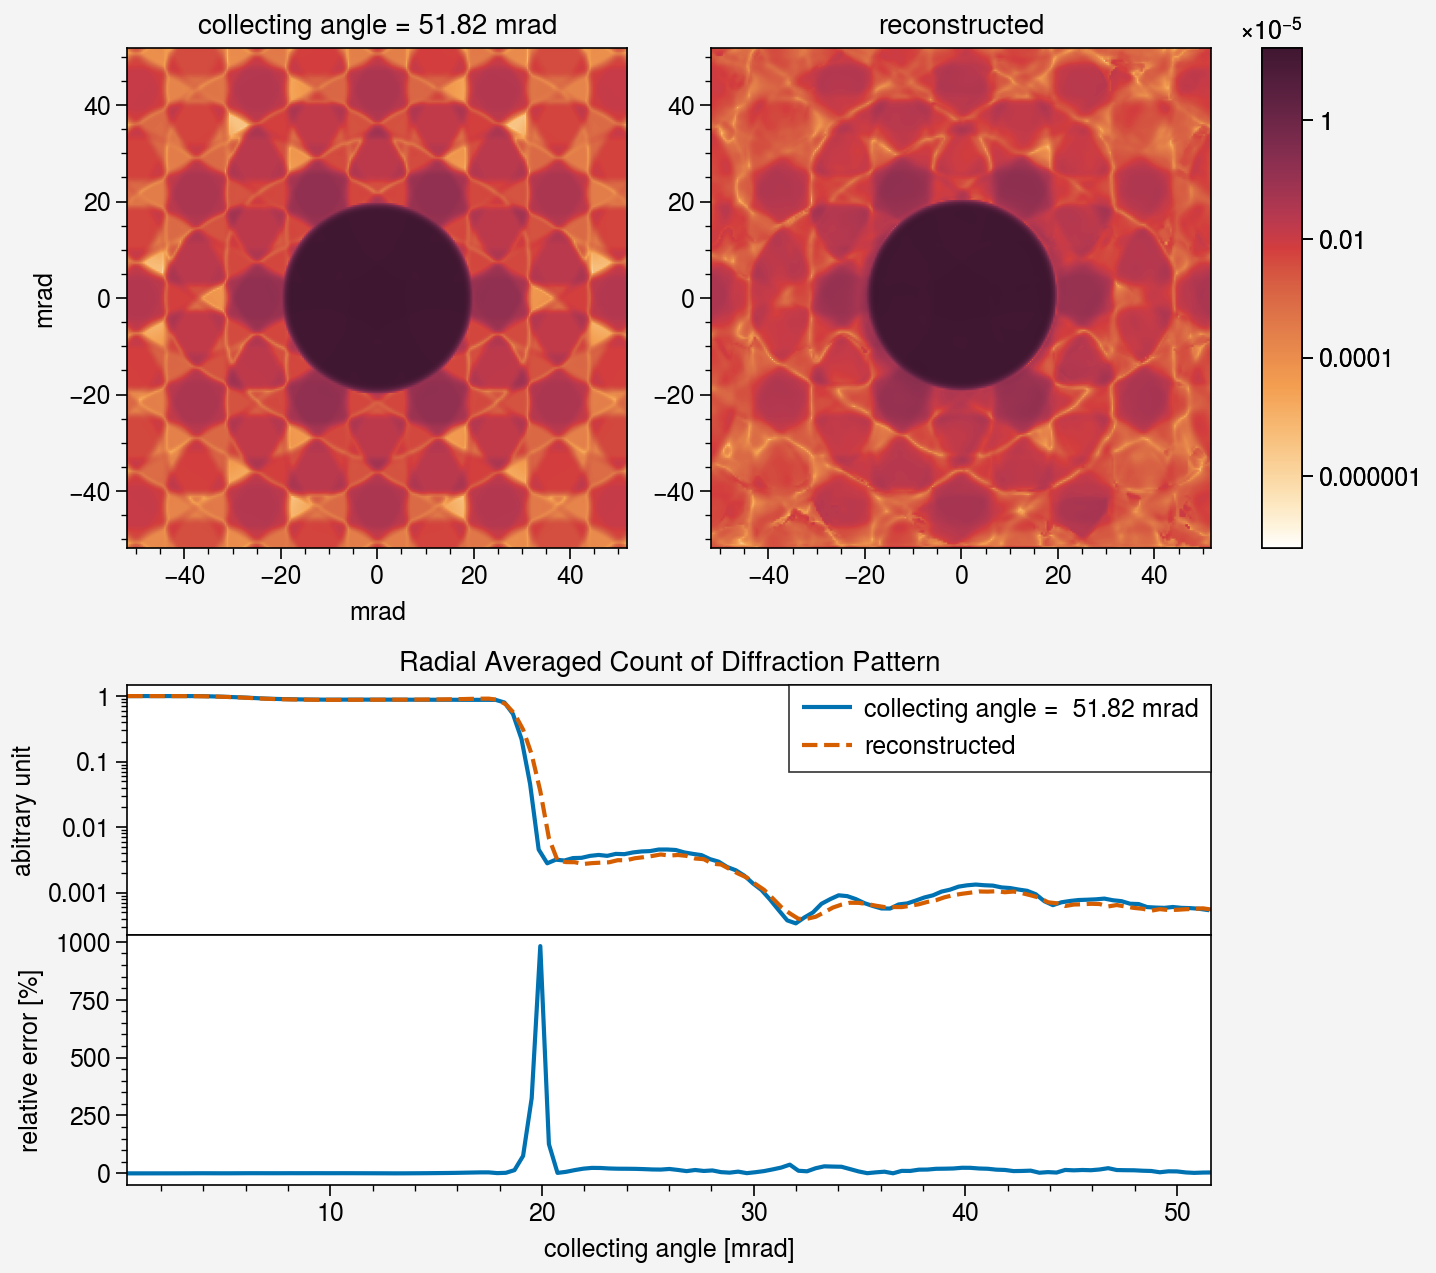

In [8]:
fig, (ax1, ax2, ax3, ax4) = pplt.subplots(
    array=[
        [1, 1, 2, 2],
        [1, 1, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4]
    ],
    share=False,
    hspace=(0, None, 0)
)
vmax = max(DP_00D.max(), dp_EPIE1_f.max())
vmin = min(DP_00D.min(), dp_EPIE1_f.min())

ax1.imshow(DP_00D, extent=[-51.8223742450, 51.8223742450, -51.8223742450, 51.8223742450],
            norm=LogNorm(),
           vmin=vmin, vmax=vmax)
ax1.format(title='collecting angle = 51.82 mrad')
m = ax2.imshow(dp_EPIE1_f, extent=[-51.8223742450, 51.8223742450, -51.8223742450, 51.8223742450],
                norm=LogNorm(),
               vmin=vmin, vmax=vmax)
ax2.format(title='reconstructed')
ax1.format(xlabel='mrad', ylabel='mrad')
fig.colorbar(m, loc='r', row=(1,2))

DP_00D_X, DP_00D_Y = racnt(DP_00D)
dp_EPIE1_f_X, dp_EPIE1_f_Y = racnt(dp_EPIE1_f)

ax3.plot(DP_00D_X[1:] * 51.8223742450 * 2, DP_00D_Y[1:],
         label='collecting angle =  51.82 mrad')
ax3.plot(dp_EPIE1_f_X[1:] * 51.8223742450 * 2, dp_EPIE1_f_Y[1:], linestyle='--',
         label='reconstructed')
ax3.format(yscale='log', title='Radial Averaged Count of Diffraction Pattern')
ax3.format(xlabel='collecting angle [mrad]', ylabel='abitrary unit')
ax3.legend(ncols=1, loc='upper right')

from scipy.interpolate import CubicSpline
f = CubicSpline(DP_00D_X, DP_00D_Y)
error_EPIE1_f = np.abs((dp_EPIE1_f_Y - f(dp_EPIE1_f_X)) / f(dp_EPIE1_f_X) * 100)
ax4.plot(dp_EPIE1_f_X[1:] * 51.8223742450 * 2, error_EPIE1_f[1:])
ax4.format(xlabel='collecting angle [mrad]', ylabel='relative error [%]')

pplt.show()


### EPIE padding 2 Diffraction Pattern Full Support

In [9]:
import h5py
from numpy import fft

with h5py.File(r'd:\Users\yiran.lu\Nextcloud\122 - WSe2 Simulation\dataset_025\results\task_SimWSe2_025_PtyPy_EPIE_100_padding_2_full_support\recons\ipykernel_launcher_EPIE_pycuda_0100.ptyr') as f:
    probe_wf = np.squeeze(f['/content/probe/Sscan_00G00/data'][()])
    trans_wf = np.squeeze(f['/content/obj/Sscan_00G00/data'][()])

dp_EPIE2_f = np.flipud(np.abs(fft.fftshift(fft.fft2(probe_wf * trans_wf[:probe_wf.shape[0], :probe_wf.shape[1]])))**2)
dp_EPIE2_f /= dp_EPIE2_f.sum()

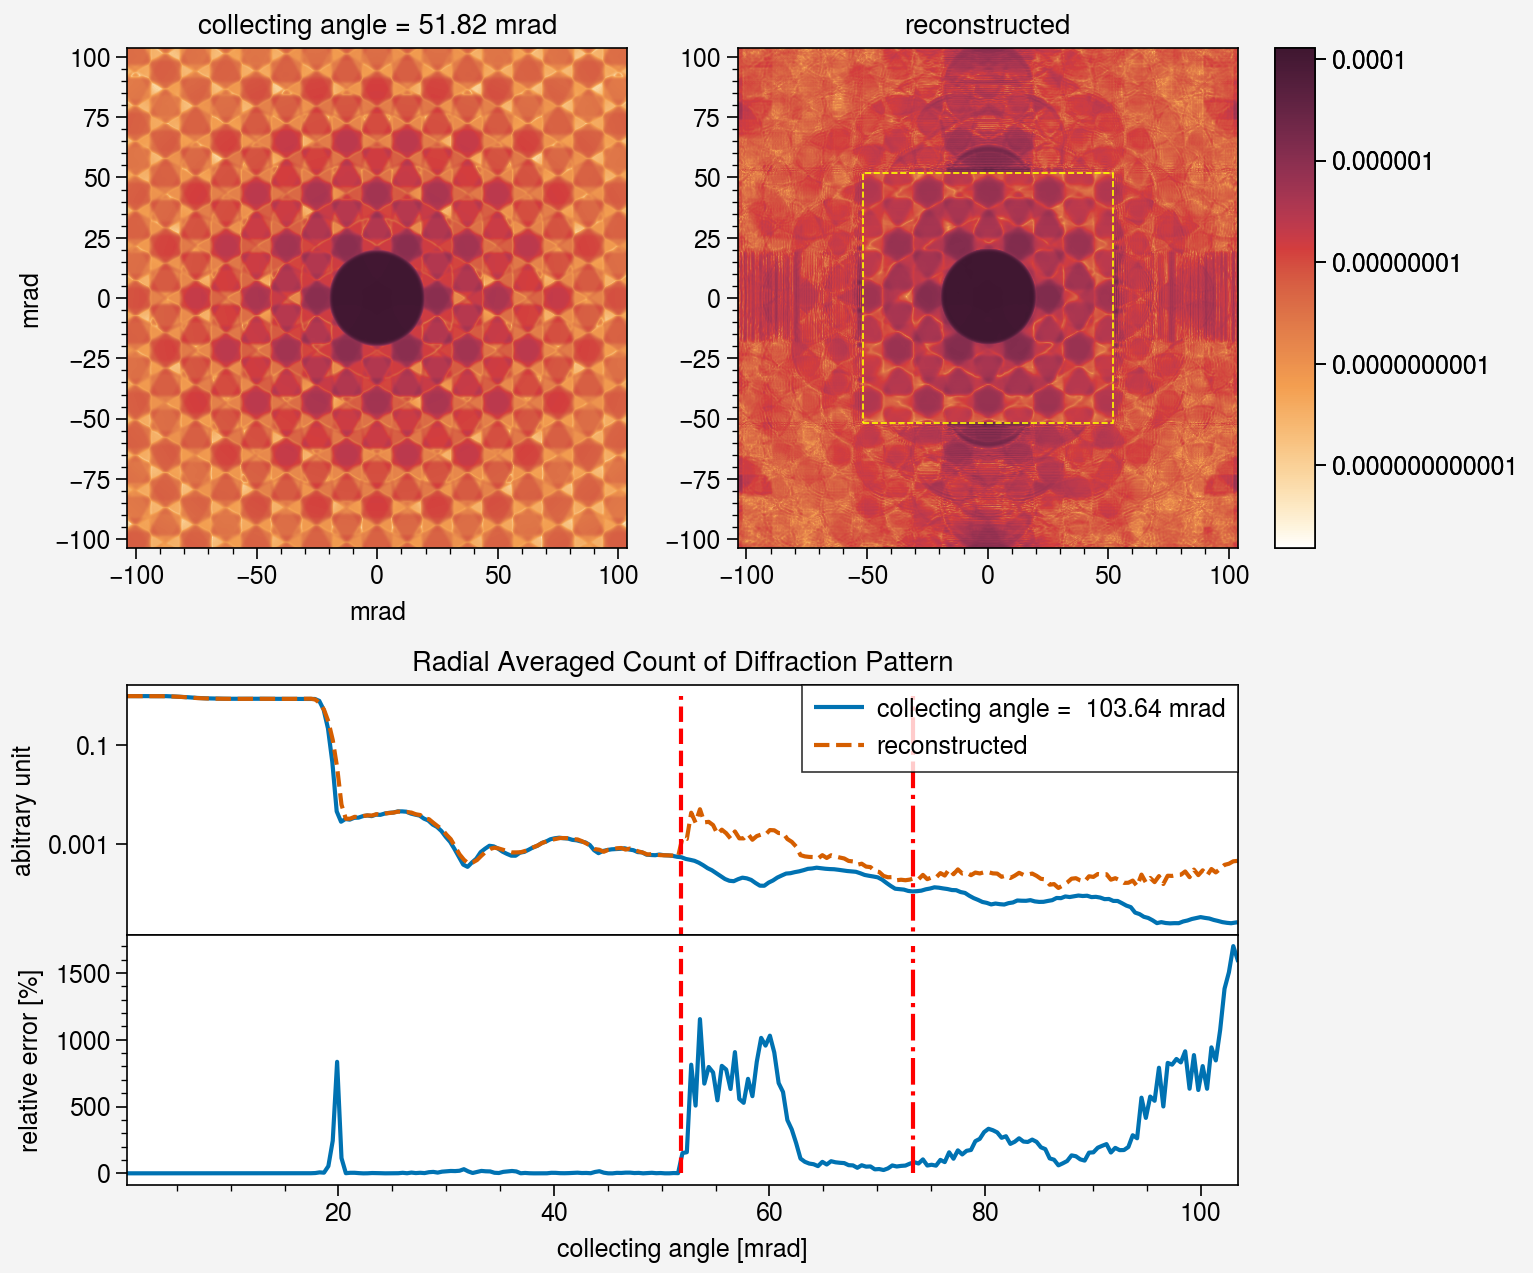

In [10]:
fig, (ax1, ax2, ax3, ax4) = pplt.subplots(
    array=[
        [1, 1, 2, 2],
        [1, 1, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4]
    ],
    share=False,
    hspace=(0, None, 0)
)
vmax = max(DP_00T.max(), dp_EPIE2.max())
vmin = min(DP_00T.min(), dp_EPIE2.min())

ax1.imshow(DP_00T, extent=[-51.8223742450*2, 51.8223742450*2, -51.8223742450*2, 51.8223742450*2],
            norm=LogNorm(),
           vmin=vmin, vmax=vmax)
ax1.format(title='collecting angle = 51.82 mrad')
m = ax2.imshow(dp_EPIE2_f, extent=[-51.8223742450*2, 51.8223742450*2, -51.8223742450*2, 51.8223742450*2],
                norm=LogNorm(),
               vmin=vmin, vmax=vmax)
ax2.format(title='reconstructed')
ax1.format(xlabel='mrad', ylabel='mrad')
ax2.add_artist(plt.Rectangle((-51.8223742450, -51.8223742450), 51.8223742450*2, 51.8223742450*2, color='yellow', fill=False, linestyle='--'))
fig.colorbar(m, loc='r', row=(1,2))

DP_00T_X, DP_00T_Y = racnt(DP_00T)
dp_EPIE2_f_X, dp_EPIE2_f_Y = racnt(dp_EPIE2_f)

ax3.plot(DP_00T_X[1:] * 51.8223742450*2 * 2, DP_00T_Y[1:],
         label='collecting angle =  103.64 mrad')
ax3.plot(dp_EPIE2_f_X[1:] * 51.8223742450*2 * 2, dp_EPIE2_f_Y[1:], linestyle='--',
         label='reconstructed')
ax3.format(yscale='log', title='Radial Averaged Count of Diffraction Pattern')
ax3.format(xlabel='collecting angle [mrad]', ylabel='abitrary unit')
ax3.legend(ncols=1, loc='upper right')

ax3.plot([51.8223742450, 51.8223742450], [0, 1], linestyle='--', color='red')
ax3.plot([np.sqrt(2)*51.8223742450, np.sqrt(2)*51.8223742450], [0, 1], linestyle='-.', color='red')

from scipy.interpolate import CubicSpline
f = CubicSpline(DP_00T_X, DP_00T_Y)
error_EPIE2_f = np.abs((dp_EPIE2_f_Y - f(dp_EPIE2_f_X)) / f(dp_EPIE2_f_X) * 100)
ax4.plot(dp_EPIE2_f_X[1:] * 51.8223742450*2 * 2, error_EPIE2_f[1:])
ax4.plot([51.8223742450, 51.8223742450], [0, error_EPIE2_f.max()], linestyle='--', color='red')
ax4.plot([np.sqrt(2)*51.8223742450, np.sqrt(2)*51.8223742450], [0, error_EPIE2_f.max()], linestyle='-.', color='red')
ax4.format(xlabel='collecting angle [mrad]', ylabel='relative error [%]')

fig.savefig("epie_df.svg")
fig.savefig("epie_df.pdf")

pplt.show()

## Aggregation

c:\Users\yiran.lu\AppData\Local\mambaforge\envs\ResearchEnvs\lib\site-packages\proplot\axes\base.py:1566: UserWarning: AutoMinorLocator does not work with logarithmic scale
  bbox = super().get_tightbbox(renderer, *args, **kwargs)
c:\Users\yiran.lu\AppData\Local\mambaforge\envs\ResearchEnvs\lib\site-packages\proplot\gridspec.py:875: UserWarning: AutoMinorLocator does not work with logarithmic scale
  bbox = fig.get_tightbbox(renderer)
c:\Users\yiran.lu\AppData\Local\mambaforge\envs\ResearchEnvs\lib\site-packages\proplot\axes\base.py:1558: UserWarning: AutoMinorLocator does not work with logarithmic scale
  super().draw(renderer, *args, **kwargs)


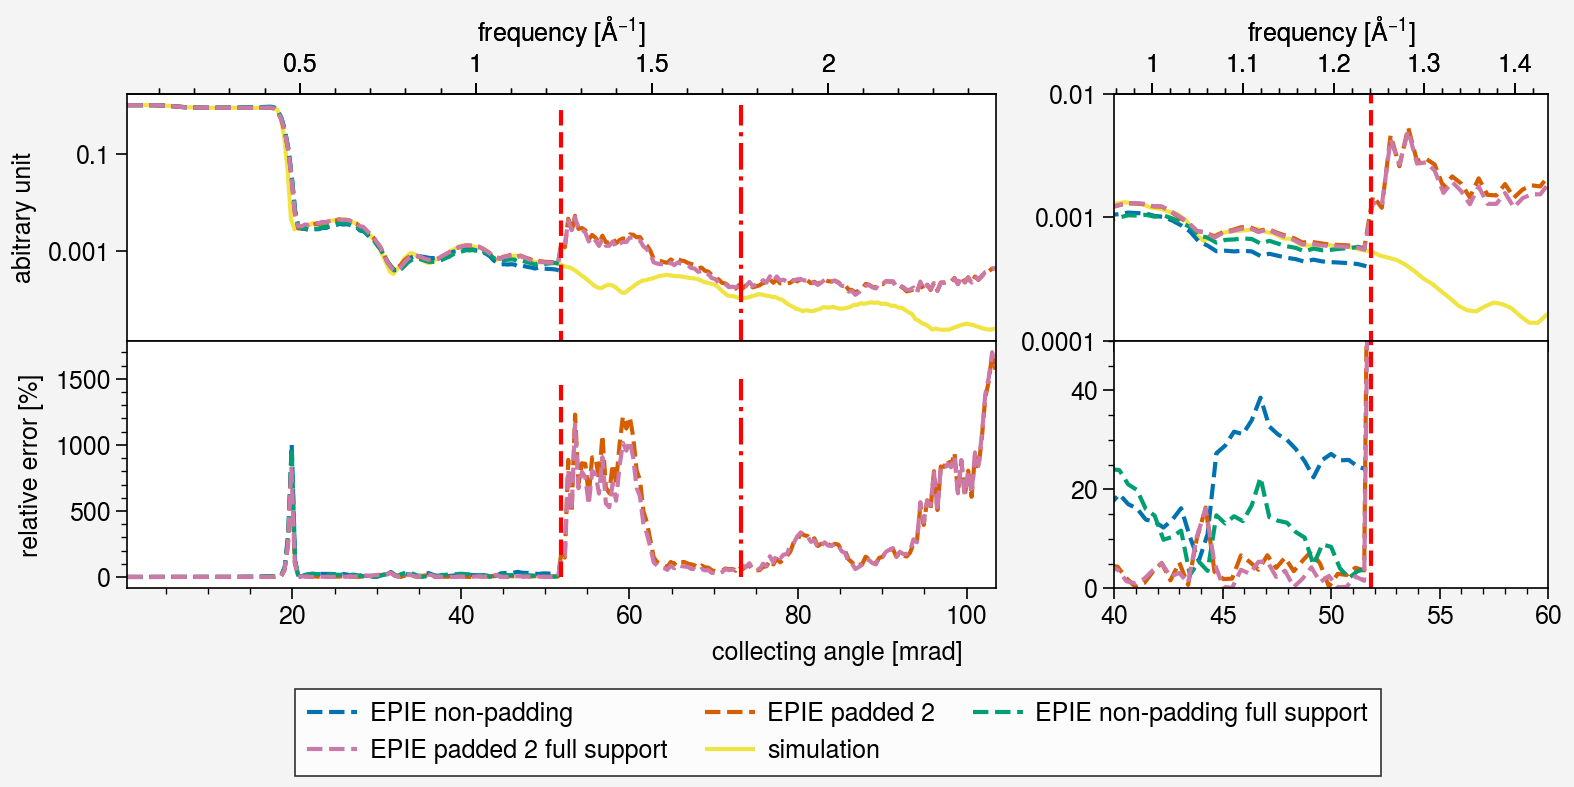

In [11]:
fig, (ax1, ax2, ax3, ax4) = pplt.subplots(
    nrows=2, ncols=2, wratios=(2, 1), hspace=(0,),
    sharey=False, sharex=True,
    figsize=("20cm", "10cm"))


ax1.plot(dp_EPIE1_X[1:] * 51.8223742450 * 2, dp_EPIE1_Y[1:], linestyle='--',
        label='EPIE non-padding')
ax1.plot(dp_EPIE2_X[1:] * 51.8223742450*2 * 2, dp_EPIE2_Y[1:], linestyle='--',
        label='EPIE padded 2')
ax1.plot(dp_EPIE1_f_X[1:] * 51.8223742450 * 2, dp_EPIE1_f_Y[1:], linestyle='--',
        label='EPIE non-padding full support')
ax1.plot(dp_EPIE2_f_X[1:] * 51.8223742450*2 * 2, dp_EPIE2_f_Y[1:], linestyle='--',
        label='EPIE padded 2 full support')
ax1.plot(DP_00T_X[1:] * 51.8223742450*2 * 2, DP_00T_Y[1:],
        label='simulation', zorder=-1)

ax1.format(yscale='log')
ax1.format(xlabel='collecting angle [mrad]', ylabel='abitrary unit')

ax1.plot([51.8223742450, 51.8223742450], [0, 1], linestyle='--', color='red')
ax1.plot([np.sqrt(2)*51.8223742450, np.sqrt(2)*51.8223742450], [0, 1], linestyle='-.', color='red')

ax1.dualx(lambda x: x*0.0239479883567794182, label='frequency [$\AA^{-1}$]')

ax3.plot(dp_EPIE1_X[1:] * 51.8223742450 * 2, error_EPIE1[1:], linestyle='--',)
ax3.plot(dp_EPIE2_X[1:] * 51.8223742450*2 * 2, error_EPIE2[1:], linestyle='--',)
ax3.plot(dp_EPIE1_f_X[1:] * 51.8223742450 * 2, error_EPIE1_f[1:], linestyle='--',)
ax3.plot(dp_EPIE2_f_X[1:] * 51.8223742450*2 * 2, error_EPIE2_f[1:], linestyle='--',)
ax3.plot([51.8223742450, 51.8223742450], [0, 1500], linestyle='--', color='red')
ax3.plot([np.sqrt(2)*51.8223742450, np.sqrt(2)*51.8223742450], [0, 1500], linestyle='-.', color='red')

ax3.format(ylabel='relative error [%]')

ax2.plot(dp_EPIE1_X[1:] * 51.8223742450 * 2, dp_EPIE1_Y[1:], linestyle='--',)
ax2.plot(dp_EPIE2_X[1:] * 51.8223742450*2 * 2, dp_EPIE2_Y[1:], linestyle='--',)
ax2.plot(dp_EPIE1_f_X[1:] * 51.8223742450 * 2, dp_EPIE1_f_Y[1:], linestyle='--',)
ax2.plot(dp_EPIE2_f_X[1:] * 51.8223742450*2 * 2, dp_EPIE2_f_Y[1:], linestyle='--',)
ax2.plot(DP_00T_X[1:] * 51.8223742450*2 * 2, DP_00T_Y[1:], zorder=-1)

ax2.format(yscale='log')
ax2.format(xlabel='collecting angle [mrad]')
fig.legend(ncols=3, loc='bottom')

ax2.plot([51.8223742450, 51.8223742450], [0, 1], linestyle='--', color='red')

ax2.dualx(lambda x: x*0.0239479883567794182, label='frequency [$\AA^{-1}$]')

ax2.format(xlim=(40,60), ylim=(0.0001, 0.01))

ax4.plot(dp_EPIE1_X[1:] * 51.8223742450 * 2, error_EPIE1[1:], linestyle='--',)
ax4.plot(dp_EPIE2_X[1:] * 51.8223742450*2 * 2, error_EPIE2[1:], linestyle='--',)
ax4.plot(dp_EPIE1_f_X[1:] * 51.8223742450 * 2, error_EPIE1_f[1:], linestyle='--',)
ax4.plot(dp_EPIE2_f_X[1:] * 51.8223742450*2 * 2, error_EPIE2_f[1:], linestyle='--',)
ax4.plot([51.8223742450, 51.8223742450], [0, 50], linestyle='--', color='red')
ax4.format(ylim=(0,50))

pplt.show()



In [12]:
import matplotlib
matplotlib.__version__

'3.4.3'